# Anime Recommendations #

## Introduction ##
This is a project to work with a large dataset directly from myanimelist.com API and create a recommendation algorithm to recommend shows based on user preferences.

The dataset contains over 10k+ anime including information like genre and rating

## Table of Contents ##

- Objectives:

    - Preprocessing
        - Data loading
        - Data visualization
        - Data cleaning
        - Data mapping

    - Models
        - scikit-surprise SVD reader
        - Pearson's R correlation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

sns.set_style("darkgrid")

# Data Preprocessing #

The anime dataset, the main one that we are going to use contains these columns:

- anime_id: the id of the anime from MAL API
- name: name of the anime
- genre: lists multiple genres that the show is categorized in
- type: movie, TV, OVA, etc
- episodes: number of episodes in the show (1 if it is a movie)
- rating: average rating out of 10
- members: group of community members that are in the anime's "group"

Another dataset, rating.csv, has the data of all the users who gave each anime on MAL (myanimelist.net) a rating with the columns:

- user_id: the user id of each account on MAL
- anime_id: the id of the anime
- rating: the rating that the user gave for the specific anime

rst we load the dataset and grab all of its detailed information to check for missing data or types of variables

In [2]:
def weighted_average(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

Using the pandas library, we read both csv's and convert them into dataframes using the read_csv method

In [3]:
anime_df = pd.read_csv("anime.csv", index_col=False)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
user_df = pd.read_csv("rating.csv", index_col=False)
user_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Using info and describe, we can see the number of items in each column that are not null and the type of the column as well. Describe will give us a 5 number summary on the non-categorical variables in the dataframe

In [5]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


In [6]:
anime_df.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


There is a clear difference in numbers for each column, so we use the dropna method to drop each row that has a null variable to give us a better model later down the road

In [7]:
#some comments about removing null cells
anime_df = anime_df.dropna()
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12017 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12017 non-null  int64  
 1   name      12017 non-null  object 
 2   genre     12017 non-null  object 
 3   type      12017 non-null  object 
 4   episodes  12017 non-null  object 
 5   rating    12017 non-null  float64
 6   members   12017 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 751.1+ KB


New columns are created in order to make processing the data easier and it will make it more easy to implement visualization of the data

In [8]:
anime_df['rating_rounded'] = anime_df['rating'].round()
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,rating_rounded
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,9.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,9.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,9.0


In [9]:
anime_df['episodes'] = anime_df['episodes'].astype(str)
anime_df['episodes'] = pd.to_numeric(anime_df['episodes'], errors = 'coerce', downcast = 'integer')
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,rating_rounded
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0


In [10]:
bins = [0, 1, 13, 25, 10000]
labels = ['movie/OVA', 'seasonal', 'long', 'extra long']
anime_df['length'] = pd.cut(anime_df['episodes'], bins = bins, labels = labels)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,rating_rounded,length
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0,movie/OVA
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0,extra long
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0,extra long
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0,long
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0,extra long


In [11]:
bins = [0, 5000, 99999999]
labels = ['false', 'true']
anime_df['popularity'] = pd.cut(anime_df['members'], bins = bins, labels = labels)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,rating_rounded,length,popularity
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0,movie/OVA,true
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0,extra long,true
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0,extra long,true
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0,long,true
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0,extra long,true


In [12]:
anime_df['genre'].astype(str)
anime_df['genre'].str.split(pat = ',')
anime_df['genre'].unique()

#will search in each element if value is in list

# parse = anime_df['genre'].apply(lambda x: [value] not in x)
# df_copy = anime_df[parse]
# df_copy


array(['Drama, Romance, School, Supernatural',
       'Action, Adventure, Drama, Fantasy, Magic, Military, Shounen',
       'Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen',
       ..., 'Action, Comedy, Hentai, Romance, Supernatural',
       'Hentai, Sports', 'Hentai, Slice of Life'], dtype=object)

# Data Visualization #

Using the seaborn, library we can compare variables in the anime dataframe to look for trends to see if we are able to trim data or make adjustments as needed to prevent bias.

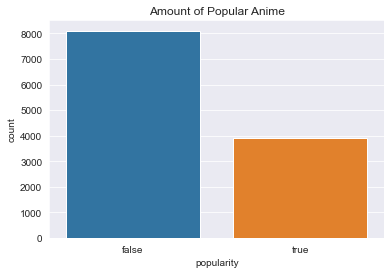

In [13]:
plot = sns.countplot(x = anime_df['popularity'])
plot.set(title = 'Amount of Popular Anime')
plt.show()

We can see that there are a lot of anime that aren't considered popular (5000 or less people have watched it/given it a rating) which means that there is a lot of extra anime on the list that may or may not be significant

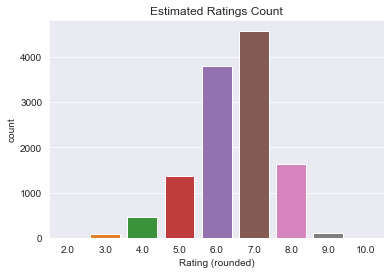

In [14]:
plot = sns.countplot(x = anime_df['rating_rounded'])
plot.set(xlabel = 'Rating (rounded)', title = 'Estimated Ratings Count')
plt.show()

Most users are giving ratings around 6 or 7 which means that there are not many people leaving bad ratings, which is likely since they would not put the effort into giving it a bad rating if they didn't enjoy it.

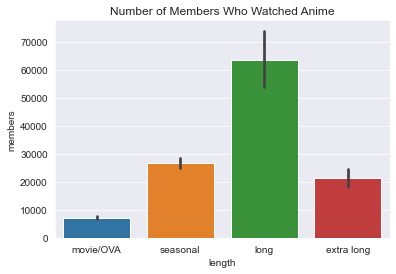

In [15]:
plot = sns.barplot(data = anime_df, x = 'length', y = 'members')
plot.set(title = 'Number of Members Who Watched Anime')
plt.show()

There is a significant difference with the amount of members that watch long anime (25 episodes) compared to seasonal or extra long type anime (25+) which can be related to older anime which used to have 25 episodes 

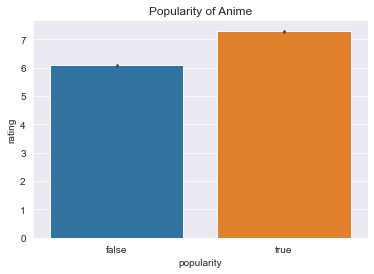

In [16]:
plot = sns.barplot(data = anime_df, x = 'popularity', y = 'rating')
plot.set(title = 'Popularity of Anime')
plt.show()

The average rating of popular anime, which does not have a large difference which means that the smaller audiences enjoyed the anime that they watched

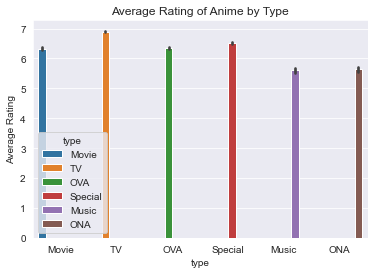

In [17]:
plot = sns.barplot(x = anime_df['type'], y = anime_df['rating_rounded'], hue= anime_df['type'])
plot.set(ylabel = 'Average Rating', title = 'Average Rating of Anime by Type')
plt.show()

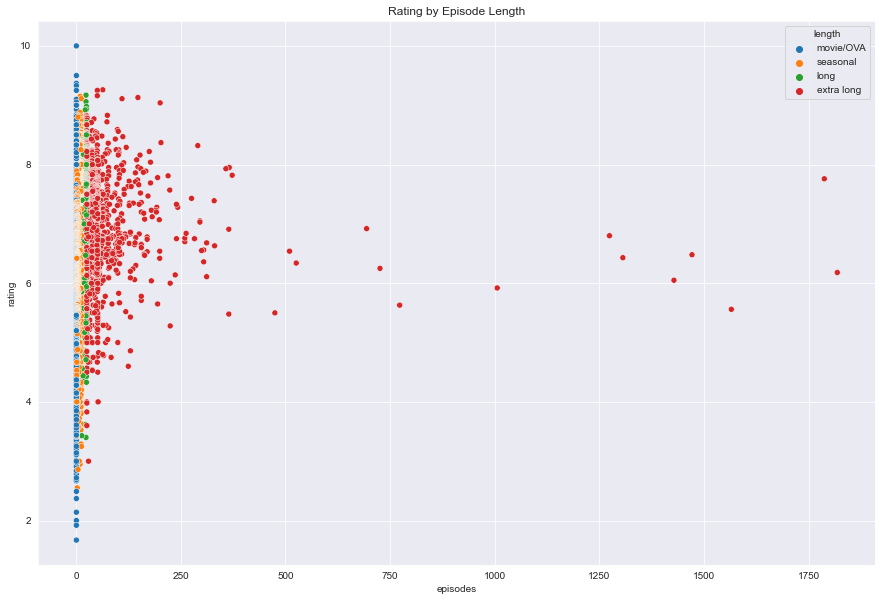

In [18]:
plt.figure(figsize = (15, 10))
plot = sns.scatterplot(x = anime_df['episodes'], y = anime_df['rating'], hue = anime_df['length'])
plot.set(title = 'Rating by Episode Length')
plt.show()

The spread is the same as the bar plot in the beginning which means that there is not very much impact on the some variables to the rating

<AxesSubplot:>

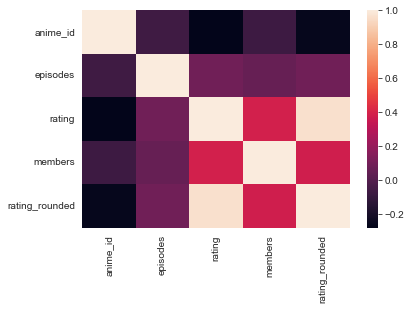

In [19]:
sns.heatmap(data = anime_df.corr())

Visualization of the correlation of each non categorical variable which shows that the strongest correlation is the number of episodes that affect everything 

# Data Cleaning #
There are unneeded variables and categories that can be removed as well as more context that can be extracted from the dataframe without visuals as well as the other dataframe

In [20]:
anime_df.drop(anime_df[anime_df['type'] == ('Music', 'Special')].index, inplace = True)
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,rating_rounded,length,popularity
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1.0,9.37,200630,9.0,movie/OVA,true
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0,extra long,true
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.25,114262,9.0,extra long,true
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24.0,9.17,673572,9.0,long,true
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51.0,9.16,151266,9.0,extra long,true


In [21]:
df_copy = anime_df.groupby('genre').apply(weighted_average, 'rating', 'members').sort_values(ascending = False)
df_copy 

genre
Action, Adventure, Drama, Fantasy, Magic, Military, Shounen     9.260000
Drama, Romance, School, Supernatural                            9.221306
Drama, Fantasy, Romance, Slice of Life, Supernatural            9.060000
Drama, School, Shounen                                          9.050000
Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen    9.042926
                                                                  ...   
Kids, Mecha                                                     3.260000
Action, Adventure, Sci-Fi, Space, Super Power                   3.250000
Dementia, Kids                                                  3.210000
Comedy, Dementia, Fantasy, Horror, Music, Parody                2.550000
Horror, Sci-Fi                                                  2.466348
Length: 3229, dtype: float64

In [22]:
def genre_separator(element):
    counts = {}
    element = element.split(',')
    for genre in element:
        if genre not in counts:
            counts[genre] = 1
        else:
            counts[genre] += 1
    return counts

In [23]:
genre_counts = {}
parse = anime_df['genre'].apply(lambda x: genre_separator(x))

parse = parse.tolist()

for dictionary in parse:
    for key in dictionary:
        if key not in genre_counts:
            genre_counts[key] = dictionary[key]
        else:
            genre_counts[key] += dictionary[key]


genre_counts

{'Drama': 974,
 ' Romance': 1344,
 ' School': 1134,
 ' Supernatural': 987,
 'Action': 2768,
 ' Adventure': 871,
 ' Drama': 1003,
 ' Fantasy': 1758,
 ' Magic': 688,
 ' Military': 396,
 ' Shounen': 1635,
 ' Comedy': 1428,
 ' Historical': 629,
 ' Parody': 388,
 ' Samurai': 144,
 ' Sci-Fi': 1955,
 'Sci-Fi': 81,
 ' Thriller': 85,
 'Comedy': 3147,
 ' Sports': 491,
 ' Super Power': 450,
 ' Space': 376,
 ' Slice of Life': 1101,
 ' Mecha': 814,
 'Adventure': 1445,
 ' Music': 450,
 ' Mystery': 414,
 ' Seinen': 522,
 'Fantasy': 484,
 ' Martial Arts': 259,
 ' Vampire': 99,
 ' Shoujo': 581,
 ' Horror': 290,
 ' Police': 194,
 ' Psychological': 204,
 'Mystery': 71,
 'Psychological': 22,
 ' Demons': 203,
 'Ecchi': 64,
 ' Josei': 49,
 'Josei': 3,
 'Military': 20,
 'Romance': 93,
 ' Shounen Ai': 62,
 ' Game': 140,
 'Demons': 84,
 ' Ecchi': 564,
 'Dementia': 205,
 ' Harem': 272,
 'Music': 392,
 'Game': 37,
 ' Cars': 37,
 ' Dementia': 33,
 'Cars': 35,
 'Mecha': 115,
 'Horror': 72,
 'School': 42,
 ' Kids':

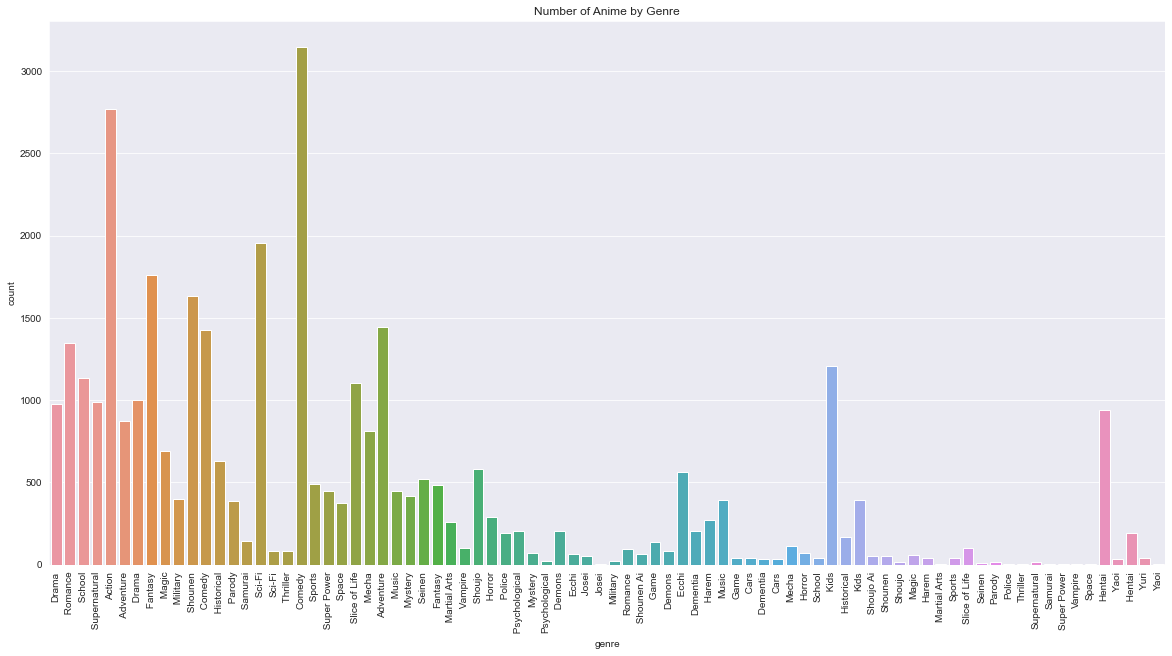

In [24]:
genre_occur = pd.DataFrame(data = list(genre_counts.items()), columns = ['genre', 'count'])
genre_occur

figure(figsize = (20, 10))
plot = sns.barplot(data = genre_occur, x = 'genre', y = 'count')
plot.set(title = 'Number of Anime by Genre')
plot.set_xticklabels(genre_occur['genre'], rotation = 90)
plt.show()

In [25]:
genre_occur['average_rating'] = 0
for key in genre_counts:
    parse = anime_df['genre'].apply(lambda x: key in x)
    temp_df = anime_df[parse]
    genre_occur.loc[genre_occur[genre_occur['genre'] == key].index, 'average_rating'] = weighted_average(temp_df, 'rating', 'members')

genre_occur
    


,genre,count,average_rating
0,Drama,974,7.903136
1,Romance,1344,7.650901
2,School,1134,7.665066
3,Supernatural,987,7.826794
4,Action,2768,7.739501
...,...,...,...
77,Hentai,940,6.558099
78,Yaoi,36,6.462542
79,Hentai,193,6.584938
80,Yuri,41,6.486908


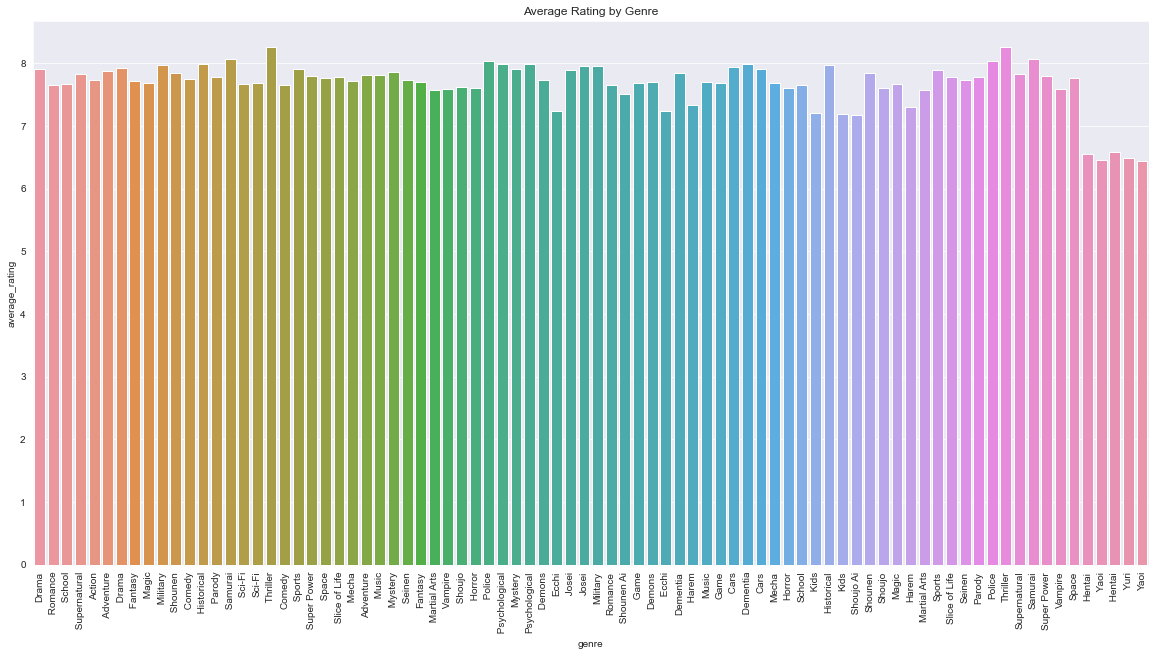

In [26]:
figure(figsize = (20, 10))
plot = sns.barplot(data = genre_occur, x = 'genre', y = 'average_rating')
plot.set(title = 'Average Rating by Genre')
plot.set_xticklabels(genre_occur['genre'], rotation = 90)
plt.show()

Since the categories are not split properly, there is no clear line between the genres and the rating, but drama and shounen tend to be the highest rated anime

In [27]:
df_copy = anime_df.groupby('length').apply(weighted_average, 'rating', 'members').sort_values(ascending = False)
df_copy 

length
long          8.026480
extra long    7.986514
movie/OVA     7.565946
seasonal      7.496495
dtype: float64

The average rating by length is around the same across the board which means that there is not a strong correlation between rating and length

In [28]:
df_copy = anime_df.groupby('type').apply(weighted_average, 'rating', 'members').sort_values(ascending = False)
df_copy 

type
Movie      7.847446
TV         7.753406
Special    7.306274
OVA        7.220818
ONA        7.013586
Music      6.992603
dtype: float64

ame point with type, but since movies have a higher production value, they tend to have higher ratings on average

In [29]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


# Trimming #

Here we trim down the user dataframe since the file is so big that there is a chance of a memory failure and the runtime will also be long if the memory doesn't fail, so we first remove all the rows with rating = -1 which means that they did not rate it, then we calculate the threshold of the amount of anime ratings a user has done to consider them active or not

In [30]:
user_df.drop(user_df[user_df['rating'] == -1].index, inplace=True)
user_df.head()

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10


In [31]:
parameters = ['count', 'mean']

user_df_summary = user_df.groupby('user_id')['rating'].agg(parameters)
user_df_summary.index = user_df_summary.index.map(int)
user_benchmark = round(user_df_summary['count'].quantile(0.7), 0)
user_drop_list = user_df_summary[user_df_summary['count'] < user_benchmark].index

anime_df_summary = user_df.groupby('anime_id')['rating'].agg(parameters)
anime_df_summary.index = anime_df_summary.index.map(int)
anime_benchmark = round(anime_df_summary['count'].quantile(0.7), 0)
anime_drop_list = anime_df_summary[anime_df_summary['count'] < anime_benchmark].index


print(f'Minimum user times of review {user_benchmark}')
print(f'Minimum anime reviews {anime_benchmark}')

Minimum user times of review 95.0
Minimum anime reviews 254.0


In [32]:
print(f'user_df original shape: {user_df.shape}')
user_df = user_df[~user_df['user_id'].isin(user_drop_list)]
print(f'user_df new shape: {user_df.shape}')

print(f'anime_df original shape: {anime_df.shape}')
anime_df = anime_df[~anime_df['anime_id'].isin(anime_drop_list)]
print(f'anime_df new shape: {anime_df.shape}')

user_df original shape: (6337241, 3)
user_df new shape: (4856518, 3)
anime_df original shape: (12017, 10)
anime_df new shape: (5111, 10)


We create a pivot table in order to summarize the data more easily and for it to help us with creating the model later on

In [75]:
anime_df_pivot = pd.pivot(user_df, values = 'rating', index = 'user_id', columns = 'anime_id')
anime_df_pivot

anime_id,1,5,6,7,8,15,16,17,18,19,...,34238,34239,34240,34252,34283,34324,34325,34349,34367,34475
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,8.0,NaN,NaN,6.0,NaN,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,10.0,...,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73503,9.0,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73504,10.0,10.0,9.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73507,9.0,8.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
user_df

,user_id,anime_id,rating
302,5,6,8
303,5,15,6
304,5,17,6
305,5,18,6
306,5,20,6
...,...,...,...
7813730,73515,13659,8
7813731,73515,14345,7
7813732,73515,16512,7
7813733,73515,17187,9


# Modeling #
Here, we will load data for a specific user id, and use that data in order to create a model based on the specific user's preferences and likes. The model used is SVD and pearson's R which will automatically give a list of recommendations of shows to watch based on the previously known data

In [35]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

reader = Reader()

dataset = Dataset.load_from_df(user_df[['user_id', 'anime_id', 'rating']], reader)

svd = SVD()
cross_validate(svd, dataset, measures=['RMSE', 'MAE'])



{'test_rmse': array([3.11670905, 3.11341398, 3.11295235, 3.11429851, 3.11264701]),
 'test_mae': array([2.80323205, 2.80135185, 2.79957899, 2.80169316, 2.79922422]),
 'fit_time': (210.43974423408508,
  217.63609409332275,
  202.92668056488037,
  201.5159080028534,
  206.2245864868164),
 'test_time': (16.23135232925415,
  10.4194815158844,
  13.655983924865723,
  10.737346410751343,
  10.838460683822632)}

Here we will load the preferences of user 66789 and create a model based on that user, anything beyond this point can be used with whatever user id that exists

In [36]:
df_66789 = user_df[(user_df['user_id'] == 66789) & (user_df['rating'] >= 7)]

df_66789 = df_66789.set_index('anime_id')
df_66789 = df_66789.join(anime_df, lsuffix = '_user', rsuffix = '_mal')['name']
df_66789.dropna(inplace=True)
df_66789

anime_id
1                         Fullmetal Alchemist: Brotherhood
18                            Ookami Kodomo no Ame to Yuki
20                                          Hajime no Ippo
24                                           Mononoke Hime
33                     Mushishi Zoku Shou: Suzu no Shizuku
43                                               Haikyuu!!
47                                 Ping Pong The Animation
57       Ano Hi Mita Hana no Namae wo Bokutachi wa Mada...
67                              Kiseijuu: Sei no Kakuritsu
93                                           Chihayafuru 2
94                                               Fate/Zero
121                      Kino no Tabi: The Beautiful World
134                                        Owarimonogatari
170                                 Tenkuu no Shiro Laputa
185                           Danshi Koukousei no Nichijou
186                                       Kotonoha no Niwa
187      Kyoukai no Kanata Movie: I&#039;ll Be 

Here we fit the model, since we fit with a 2 million row dataframe, the runtime will be slow
WARNING: 16 MIN RUNTIME ON A 12 CORE SYSTEM

In [37]:
user_66789  = anime_df.copy()
user_66789 = user_66789.reset_index()
user_66789 = user_66789[~user_66789['anime_id'].isin(anime_drop_list)]

combined_data = dataset

training_set = combined_data.build_full_trainset()
svd.fit(training_set)

In [38]:
user_66789['score'] = user_66789['anime_id'].apply(lambda x: svd.predict(66789, x).est)

user_66789 = user_66789.drop(['anime_id', 'index'], axis = 1)

user_66789 = user_66789.sort_values('members', ascending = False)
user_66789.head()

,name,genre,type,episodes,rating,members,rating_rounded,length,popularity,score
38,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37.0,8.71,1013917,9.0,extra long,true,5.0
82,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25.0,8.54,896229,9.0,long,true,5.0
712,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25.0,7.83,893100,8.0,long,true,5.0
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64.0,9.26,793665,9.0,extra long,true,5.0
154,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13.0,8.39,717796,8.0,seasonal,true,5.0


These cells use a pearson's R coefficient modeling which is another collaborative filtering model that will load preferences based on a pearsonR score that represents the correlation between 2 shows to see if it is a good fit for the user

In [57]:
def recommendation(title, min_count):
    index = int(anime_df.index[anime_df['name'] == title][0])

    target = anime_df_pivot[index]
    similarity = anime_df_pivot.corrwith(target)

    corr_t = pd.DataFrame(similarity, columns = ['PearsonR'])    corr_t.dropna(inplace = True)
    corr_t = corr_t.sort_values('PearsonR', ascending = False)
    corr_t.index = corr_t.index.map(int)
    corr_t = corr_t.join(anime_df).join(anime_df_summary)[['PearsonR', 'name', 'count', 'mean']]
    print(f'--Recommendations based on {title}--')
    print(corr_t[(corr_t['count'] > min_count) & (~corr_t['name'].isnull())][:15].to_string(index = False))




In [58]:
recommendation('91 Days', 1000)

C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


--Recommendations based on 91 Days--
 PearsonR                                                     name  count     mean
 0.702516                                      Hoozuki no Reitetsu   1102 8.302178
 0.701268                               Mahou Shoujo Madoka★Magica   1337 7.691847
 0.696673                                                 Kamichu!   1213 7.183842
 0.677109                                                HeatGuy J   1250 6.883200
 0.672820 Detective Conan Movie 17: Private Eye in the Distant Sea   1259 8.062748
 0.653003                            Diamond no Ace: Second Season   1381 7.498190
 0.647051                                               Tokyo 2164   1375 7.215273
 0.643462                  Taka no Tsume 8: Yoshida-kun no X-Files   1321 7.570780
 0.643418                                               GetBackers   1043 8.237776
 0.631048             Sore Ike! Anpanman: Tsumiki Shiro no Himitsu   1467 7.689162
 0.625661                                         

In [59]:
recommendation('Tokyo Ghoul', 1000)

C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


--Recommendations based on Tokyo Ghoul--
 PearsonR                                                                                   name  count     mean
 1.000000                                                                            Tokyo Ghoul   2245 7.650780
 0.787882                                                                         Azumanga Daioh   2406 7.724439
 0.782668                                                                    Yume-iro Pâtissière   2304 7.980035
 0.780600                                                                    Usagi Drop Specials   2558 7.823299
 0.697320                                                Saint Seiya: Meiou Hades Juuni Kyuu-hen   7603 8.040247
 0.624728                                                            Uchuu Shounen Soran (Movie)   1416 7.507062
 0.607536                                                           Kyoukai no Kanata: Shinonome   1198 7.041736
 0.579972                                              

In [60]:
recommendation('Konjiki no Gash Bell!!', 1000)

C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


--Recommendations based on Konjiki no Gash Bell!!--
 PearsonR                                                                     name  count     mean
 0.942809                                                           Sakura no Ondo   1416 7.963983
 0.891056                                                               GetBackers   1043 8.237776
 0.821584                                                             Tokyo Ravens   1353 7.162602
 0.810093                                                        Arashi no Yoru ni   1018 7.154224
 0.800364                                      Qin Shiming Yue Zhi: Junlin Tianxia   2585 8.242166
 0.797940                                              Hiiro no Kakera Dai Ni Shou   1104 7.072464
 0.782308                                                         Robby to Kerobby   1766 6.776897
 0.760726                                    Peach Command Shin Momotarou Densetsu   3109 6.796076
 0.728578                                             Kyo

In [64]:
recommendation('Fullmetal Alchemist: Brotherhood', 1000)

C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


--Recommendations based on Fullmetal Alchemist: Brotherhood--
 PearsonR                                                                         name  count     mean
 1.000000                                             Fullmetal Alchemist: Brotherhood  13449 8.869433
 0.561158                    Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou   5790 8.439724
 0.342475                                                                    Haikyuu!!   7485 8.305945
 0.329705                                                       Ouran Koukou Host Club  13679 8.807077
 0.322020                      Code Geass: Boukoku no Akito 2 - Hikisakareshi Yokuryuu   1730 8.282081
 0.315074                           Detective Conan Movie 14: The Lost Ship in the Sky  11118 8.107483
 0.314993                                                               Bakemonogatari   1250 7.901600
 0.311537                                                       Hunter x Hunter (2011)   9385 8.419393
 0.309657  

In [76]:
recommendation('Clannad', 1000)

C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\nnath\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


--Recommendations based on Clannad--
 PearsonR                                                                                   name  count     mean
 1.000000                                                                                Clannad  11696 8.169716
 0.711571                                                         Hidamari Sketch x 365 Specials  14211 8.314967
 0.573559                                                                      Minami-ke Tadaima   1112 7.366007
 0.566722                                                          Zoku Sayonara Zetsubou Sensei   1363 7.090242
 0.560871                                                                             Texhnolyze   2272 7.576144
 0.558972                                                                       Momo e no Tegami   2790 6.989606
 0.549859                                                           Kyoukai no Kanata: Shinonome   1198 7.041736
 0.546877                                                  